## **Описание проекта**

В рамках проекта необходимо написать несколько SQL-запросов для базы данных платформы Stack Overflow. Таблица users содержат данные за 2008 год о зарегистрированных пользователях Stack Overflow. Таблица posts - данные о размещенных на платформе постах (также за 2008 год). 

 Подключимся к базе с помощью SQLAlchemy

In [ ]:
!pip install sqlalchemy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

In [ ]:
sns.set()

Создадим конфигурацию для подключения к базе данных data-analyst-advanced-sql, которая содержит схему, необходимую нам для дальнейшей работы

In [ ]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [ ]:
engine = create_engine(connection_string) 

In [ ]:
def select(sql):
  return pd.read_sql_query(sql, con = engine) 

## **Задание 1**

Выведите общую сумму просмотров постов за каждый месяц 2008 года. 

Посмотрим, за какие месяцы 2008 года у нас собраны данные о постах на Stack Overflow

In [ ]:
sql = '''
SELECT MIN(creation_date), MAX(creation_date)
FROM stackoverflow.posts
LIMIT 5
''' 

select(sql)

,min,max
0,2008-07-31 21:42:53,2008-12-30 23:59:15


Данные представлены за неполных шесть месяцев 2008 года. Причем за июль у нас есть данные только за один последний день месяца. Будем это иметь в виду при дальнейшем анализе данных.

In [ ]:
sql = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month, SUM(views_count) AS views_cnt
FROM stackoverflow.posts
GROUP BY DATE_TRUNC('month', creation_date)::date
ORDER BY 1
''' 

select(sql)

,month,views_cnt
0,2008-07-01,669895
1,2008-08-01,131367083
2,2008-09-01,452928568
3,2008-10-01,365400138
4,2008-11-01,221759651
5,2008-12-01,197792841


In [ ]:
t = select(sql)

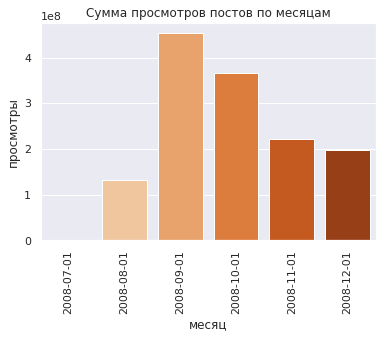

In [ ]:
sns.barplot(x='month', y='views_cnt', data=t, palette='Oranges')
plt.xlabel("месяц")
plt.ylabel("просмотры")
plt.title("Сумма просмотров постов по месяцам")
plt.xticks(rotation=90);

Мы видим, что данные по просмотрам существенно варьируются от месяца к месяцу. Наибольшие показатели наблюдались в сентябре и октябре, причем в сентябре просмотры выросли в несколько раз по сравнению с августом (со 130 млн до 450 млн). После такого резкого скачка наблюдается постепенное снижение просмотров вплоть до декабря 2008 года. 
Такая активность в сентябре-октябре может объясняться окончанием каникул и началом учебного года. 
Минимальное кол-во просмотров зафиксировано в июле (всего 670 тыс.), однако, мы уже выяснили, что данные за этот месяц у нас неполные.

## **Задание 2**

На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

+ номер месяца;
+ количество постов за месяц;
+ процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

In [ ]:
sql = '''
WITH
t AS (SELECT EXTRACT(MONTH FROM creation_date) AS month, 
COUNT(DISTINCT id) AS posts_cnt
FROM stackoverflow.posts
WHERE DATE_TRUNC('DAY', creation_date)::date BETWEEN '2008-08-01' AND '2008-12-31'
GROUP BY EXTRACT(MONTH FROM creation_date))

SELECT month::int, posts_cnt, 
ROUND(CAST(posts_cnt - LAG(posts_cnt, 1, NULL) OVER(ORDER BY month) AS numeric)/LAG(posts_cnt) OVER(ORDER BY month)*100, 2) AS change
FROM t
''' 

select(sql)

,month,posts_cnt,change
0,8,18750,NaN
1,9,70371,275.31
2,10,63102,-10.33
3,11,46975,-25.56
4,12,44592,-5.07


In [ ]:
t = select(sql)

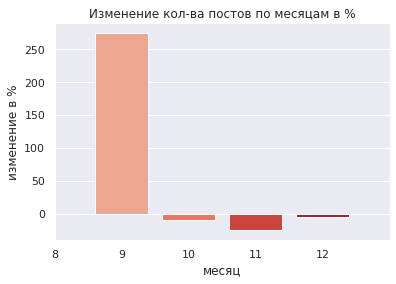

In [ ]:
sns.barplot(x='month', y='change', data=t, palette='Reds')
plt.xlabel("месяц")
plt.ylabel("изменение в %")
plt.title("Изменение кол-ва постов по месяцам в %")
plt.xlim(0,5);

Мы наблюдаем схожую картину с приростом кол-ва постов, что и с количеством просмотров: трехкратный рост в сентябре по сравнению с августом и затем снижение кол-ва постов вплоть до декабря 2008 года.

## **Задание 3**

Посчитайте ежедневный прирост новых пользователей по месяцам.

In [ ]:
sql = '''
WITH 
aug AS (SELECT EXTRACT(DAY FROM creation_date) AS dt, COUNT(DISTINCT id) AS august
FROM stackoverflow.users
WHERE DATE_TRUNC('month', creation_date)::date = '2008-08-01'
GROUP BY EXTRACT(DAY FROM creation_date)), 

sept AS (SELECT EXTRACT(DAY FROM creation_date) AS dt, COUNT(DISTINCT id) AS september
FROM stackoverflow.users
WHERE DATE_TRUNC('month', creation_date)::date = '2008-09-01'
GROUP BY EXTRACT(DAY FROM creation_date)),

oct AS (SELECT EXTRACT(DAY FROM creation_date) AS dt, COUNT(DISTINCT id) AS october
FROM stackoverflow.users
WHERE DATE_TRUNC('month', creation_date)::date = '2008-10-01'
GROUP BY EXTRACT(DAY FROM creation_date)),

nov AS (SELECT EXTRACT(DAY FROM creation_date) AS dt, COUNT(DISTINCT id) AS november
FROM stackoverflow.users
WHERE DATE_TRUNC('month', creation_date)::date = '2008-11-01'
GROUP BY EXTRACT(DAY FROM creation_date)), 

dec AS (SELECT EXTRACT(DAY FROM creation_date) AS dt, COUNT(DISTINCT id) AS december
FROM stackoverflow.users
WHERE DATE_TRUNC('month', creation_date)::date = '2008-12-01'
GROUP BY EXTRACT(DAY FROM creation_date))

SELECT aug.dt::int, aug.august, sept.september, oct.october, nov.november, dec.december
FROM aug
LEFT JOIN sept ON aug.dt=sept.dt
LEFT JOIN oct ON aug.dt=oct.dt
LEFT JOIN nov ON aug.dt=nov.dt
LEFT JOIN dec ON aug.dt=dec.dt

''' 

select(sql)

,dt,august,september,october,november,december
0,1,77,127.0,137,34.0,75.0
1,2,52,149.0,122,48.0,101.0
2,3,53,70.0,127,75.0,90.0
3,4,82,100.0,63,192.0,86.0
4,5,83,118.0,70,122.0,102.0
5,6,86,64.0,110,132.0,53.0
6,7,74,104.0,119,104.0,32.0
7,8,66,115.0,132,42.0,56.0
8,9,60,105.0,126,45.0,98.0
9,10,60,99.0,112,93.0,101.0


In [ ]:
t = select(sql)

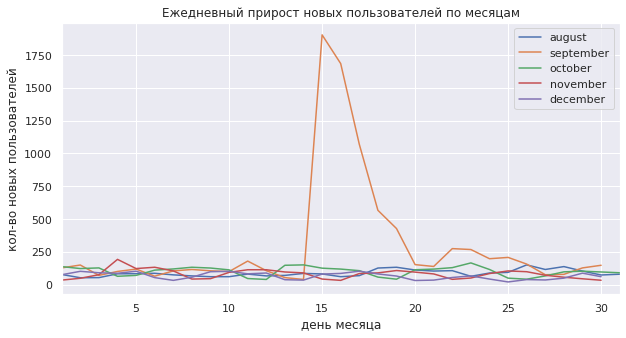

In [ ]:
t.plot(x='dt', figsize = (10,5))
plt.xlabel('день месяца')
plt.ylabel('кол-во новых пользователей')
plt.title("Ежедневный прирост новых пользователей по месяцам")
plt.xlim(1,31)
plt.show();

На графике видно, что на середину сентября приходится резкий всплеск прироста новых пользователей на платформе Stack Overflow: 15 сентября число вновь зарегистрированных пользователей выросло до 1900 чел. с 39 чел. в предыдущий день. В последующие два дня (16 и 17 сентября) прирост, хотя и снизился, но оставался, в целом, выше средних показателей - 1600 и 1000 чел. в день. В другие месяцы подобных всплесков не наблюдалось и показатели прироста колебались в едином коридоре. 

Такой резкий прирост пользователей в сентябре объясняет повышенную активность пользователей в сентябре-октябре. 

Поскольку сентябрьский рост пришелся на середину месяца, а не на его начало, и связан, судя по всему, с одной датой - 15 сентября, нашу предыдущую версию о взаимосвязи активности пользователей и началом учебного года можно отбросить. Рост активности был явно связан либо с важной датой в истории платформы, либо с какой-либо мощной пиар-акцией. Если мы проверим историю Stack Overflow, мы легко выясним, что 15 сентября 2008 года состоялся официальный глобальный запуск платформы. Так что можно с уверенностью утверждать, что такой активный прирост пользователей в этот и последующие несколько дней сентября связан именно с этим событием.  

## **Задание 4**

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений user_id. 

In [ ]:
sql = '''
WITH t as (
SELECT  p.creation_date dt_post,
        t.type,
        u.creation_date dt_user,
        p.user_id,
        display_name
FROM stackoverflow.posts p
JOIN stackoverflow.users u ON u.id = p.user_id
JOIN stackoverflow.post_types t ON t.id = p.post_type_id
WHERE (DATE_TRUNC('day', p.creation_date) <= 
(DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month')) AND type = 'Answer'
),

final_data AS (
SELECT count(distinct(user_id)) AS sum_id,
       display_name,
       count(type) AS sum_answers
FROM  t
GROUP BY display_name)


SELECT display_name,
       sum_id, sum_answers
FROM final_data
WHERE sum_answers > 100
ORDER BY sum_answers DESC
''' 

select(sql)

,display_name,sum_id,sum_answers
0,Jon Skeet,1,387
1,Joel Coehoorn,1,306
2,Marc Gravell,1,254
3,Vinko Vrsalovic,1,235
4,Johannes Schaub - litb,1,224
...,...,...,...
74,Ryan,10,103
75,1800 INFORMATION,1,102
76,Michael Stum,1,101
77,gbjbaanb,1,101


Самый активный пользователь успел дать почти 400 ответов за первый месяц после своей регистрации - весьма впечатляющий показатель. Всего же активных пользователей, которые за месяц успели дать более 100 ответов, набралось 79 человек. 

In [ ]:
sql = '''
SELECT *
FROM stackoverflow.users 
WHERE display_name = 'Ryan'
LIMIT 10
''' 

select(sql)

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1545,2008-08-16 14:28:42,Ryan,2018-08-31 21:12:07,"Houston, TX",2757,290
1,1581,2008-08-16 20:39:26,Ryan,2009-11-09 07:04:02,United States,452,42
2,5071,2008-09-07 17:36:12,Ryan,2016-10-26 23:46:55,"Los Angeles, CA, United States",647,86
3,8819,2008-09-15 16:56:21,Ryan,2018-06-29 23:16:14,"Colorado, United States",11203,715
4,11516,2008-09-16 08:50:31,Ryan,2016-04-27 16:26:02,France,285,46
5,12375,2008-09-16 14:09:31,Ryan,2009-10-23 14:25:48,"Washington, DC",108,41
6,14521,2008-09-17 00:38:04,Ryan,2018-08-31 15:35:33,New York City,3184,251
7,17917,2008-09-18 16:12:15,Ryan,2017-03-30 18:40:42,Minnesota,8892,626
8,20198,2008-09-22 04:32:05,Ryan,2018-08-24 08:34:28,United Kingdom,16055,1420
9,29762,2008-10-20 20:32:15,Ryan,2018-08-31 13:26:24,"Houston, TX",6098,515


Примечательно, что некоторым особо популярным именам пользователей, таким как Alan, Ryan, соответствует несколько user_id. Здесь мы столкнулись с интересной особенностью платформы Stack Overflow: если другие платформы обязывают пользователей выбирать только уникальные имена, то Stack Overflow позволяет пользователям выбирать имена, которые уже есть на платформе - отсуда такое большое число дубликатов. Но, как мы видим по данным регистрации, все это - разные люди, из разных городов и даже из разных стран.

## **Задание 5**

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [ ]:
sql = '''
WITH
sept AS (SELECT id
FROM stackoverflow.users
WHERE DATE_TRUNC('month', creation_date)::date = '2008-09-01'),

users AS (SELECT DISTINCT p.user_id
FROM sept
LEFT JOIN stackoverflow.posts p ON sept.id=p.user_id
WHERE DATE_TRUNC('month', p.creation_date)::date = '2008-12-01')

SELECT DATE_TRUNC('month', p.creation_date)::date AS month, COUNT(id) AS post_cnt
FROM users
LEFT JOIN stackoverflow.posts p ON users.user_id=p.user_id
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY month DESC
''' 

select(sql)

,month,post_cnt
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


В итоговой таблице наблюдается явная аномалия: пользователи, которые были зарегистрированы в сентябре, были активны и в августе. Вероятно, это связано с тем, что официальный запуск платформы состоялся только 15 сентября 2008 года, но в тестовом режиме платформа работала весь август. Вполне возможно, что в этот период могла действовать временная регистрация, а после запуска платформы ее нужно было переоформить. 

## **Задание 6**

Используя данные о постах, выведите несколько полей:

+ идентификатор пользователя, который написал пост;
+ дата создания поста;
+ количество просмотров у текущего поста;
+ сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [ ]:
sql = '''
SELECT user_id, creation_date, views_count, SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS views_cumsum
FROM stackoverflow.posts
ORDER BY user_id, creation_date
''' 

select(sql)

,user_id,creation_date,views_count,views_cumsum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


## **Задание 7**

Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число.

In [ ]:
sql = '''
WITH
t AS (SELECT user_id, DATE_TRUNC('DAY', creation_date)::date AS active_days
FROM stackoverflow.posts
WHERE DATE_TRUNC('DAY', creation_date)::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id, DATE_TRUNC('DAY', creation_date)::date),

days_cnt AS (SELECT user_id, COUNT(active_days)
FROM t
GROUP BY user_id)

SELECT AVG(count)::int AS avg_days
FROM days_cnt
''' 

select(sql)

,avg_days
0,2


В среднем пользователи взаимодействовали с платформой в период с 1 декабря по 7 декабря всего 2 дня - не так уж много, как можно было бы ожидать.

## **Задание 8**



Рассчитайте аналог Retention Rate по месяцам для пользователей Stack Overflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определите по наличию поста в текущем месяце.


In [ ]:
sql = '''
WITH
t AS (SELECT DISTINCT user_id, 
MIN(DATE_TRUNC('month', creation_date)) OVER (PARTITION BY user_id ORDER BY creation_date) AS start_dt
FROM stackoverflow.posts),

c AS (SELECT user_id, start_dt, COUNT(user_id) OVER (PARTITION BY start_dt) AS cohort_size
FROM t), 

s AS (SELECT c.*, DATE_TRUNC('month', p.creation_date) AS session_dt
FROM c
LEFT JOIN stackoverflow.posts p ON c.user_id=p.user_id
GROUP BY 1, 2, 3, 4)

SELECT start_dt::date, session_dt::date, COUNT(user_id) AS user_cnt, cohort_size, 
ROUND(COUNT(user_id) * 100.0 / cohort_size, 2) AS retention_rate
FROM s
GROUP BY 1, 2, 4
ORDER BY 1, 2
''' 

select(sql)

,start_dt,session_dt,user_cnt,cohort_size,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Построим тепловую карту для таблицы удержания

In [ ]:
t = select(sql)

In [ ]:
pivot = t.pivot_table(index='start_dt', columns='session_dt', values='retention_rate', aggfunc='mean')

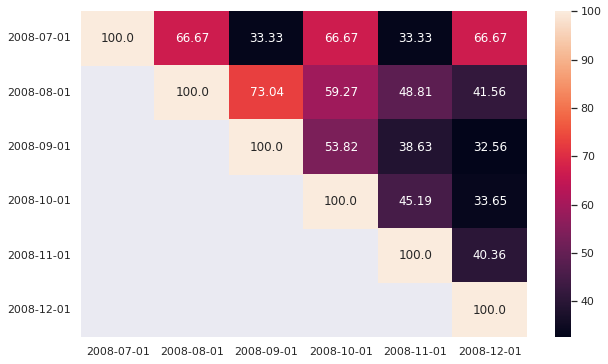

In [ ]:
plt.figure(figsize=(10, 6)) 
sns.heatmap(pivot, annot=True, fmt='')
plt.xlabel('')
plt.ylabel('')
plt.show(); 

Как видно из таблицы, июльская когорта слишком мала (3 чел.), чтобы брать ее во внимание, поэтому анализ уровня удержания имеет смысл делать, начиная с августовской когорты. Пользователи, привлеченные на Stack Overflow в августе, демонстрировали самый высокий уровень удержания первого месяца (73%). У более поздних когорт наблюдается стабильное снижение этого показателя (53% у сентябрьской когорты, 45% - у октябрьской и, наконец, 40% у ноябрьской).

У августовской когорты уровень удержания довольно высокий и в остальные месяцы: 59% во второй месяц (что даже больше, чем первый месяц удержания у всех остальных когорт), 48% - в третий месяц и 41% - четвертый месяц. 

Напомним, что в августе платформа существовала в тестовом режиме, ее официальный запуск состоялся только 15 сентября, поэтому такие хорошие показатели августовской когорты не могут не удивлять. Возможно, это объясняется фактором любопытства: пользователи, которые начали работать с платформой до ее запуска, оставались дольше, чтобы увидеть, как будет развиваться платформа в дальнейшем.  